In [1]:
#import custom modules
from importlib import reload
from helpers.my_imports import *
import helpers.preprocessing as pp
import helpers.plot as plot
import helpers.tools as tools
import helpers.transformers as xfrs
from helpers.reload import myreload

#make sure latest copy of library is loaded
myreload()

#Global Variable for Random State
rs=42 #random_state

df = pd.read_csv('saved_dfs/preprocessed_negotiations_df.csv')
df.head(2)

Reloaded helpers.preprocessing, helpers.plots, and helpers.tools.


,claim_type,NSA_NNSA,split_claim,negotiation_type,in_response_to,level,facility,carrier,group_number,plan_funding,TPA,TPA_rep,billed_amount,negotiation_amount,offer,counter_offer,decision,service_days,decision_days,offer_days,counter_offer_days,YOB,neg_to_billed,offer_to_neg,offer_to_counter_offer
0,HCFA,NNSA,No,NNSA Negotiation,Insurance Initiated,Level 3,Cedar Hill,Cigna,3344605,FULLY,Zelis,Marissa Pepe,4058.0,4058.0,258.0,3449.0,Rejected,128.0,NaN,0.0,0.0,1984,1.0,0.0636,0.0748
1,UB,NNSA,No,NNSA Negotiation,Insurance Initiated,Level 5,Cedar Hill,Blue Cross Blue Shield,174518M3BH,SELF,Zelis,Courtney Kiernan,52253.0,52253.0,12500.0,44415.0,Rejected,127.0,NaN,2.0,2.0,2021,1.0,0.2392,0.2814


## Define X, y

In [2]:
#Define X and y
X,y=df.drop(columns=['decision', 'billed_amount', 'negotiation_amount', 'offer', 'counter_offer']), df.decision

#Split and stratify the data
X_train, X_test, y_train, y_test = train_test_split(X,y, stratify=y, test_size=0.25, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((6398, 20), (2133, 20), (6398,), (2133,))

### Load Best Logistic Regression Model
While Gradient Boost performed better, we still take a look at the Logistic Regression so we can inspect the most important coefficients 

In [3]:
best_lgr = load('models/hyperparam_tuning/ht_lgr_set7.joblib')
best_lgr

Pipeline(steps=[('transformer',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('si',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('yeo',
                                                                   PowerTransformer()),
                                                                  ('poly',
                                                                   PolynomialFeatures(include_bias=False))]),
                                                  ['neg_to_billed',
                                                   'offer_to_neg',
                                                   'offer_to_counter_offer',
                                                   'offer_days',
                                                   'decision_days',
                                                   'service_days',
                                                   'counter_offer_days',
                                                   'YOB']),
                                                 ('cat',
                                                  Pip...
                ('scaler', RobustScaler()),
                ('selector',
                 SelectFromModel(estimator=LogisticRegression(max_iter=3000,
                                                              n_jobs=-1,
                                                              penalty='l1',
                                                              random_state=42,
                                                              solver='saga'),
                                 threshold=1.235962471258738e-06)),
                ('lgr',
                 LogisticRegression(C=7.387641469840879,
                                    class_weight={'Accepted': 0.2086,
                                                  'Rejected': 1},
                                    max_iter=5000, n_jobs=-1, random_state=42,
                                    solver='newton-cholesky',
                                    tol=3.278628584511121e-05))])

#### Confirm we have the right model and that train and test scores match Hyperparameter Tuning

In [4]:
f1_score(y_train,best_lgr.predict(X_train), average='weighted'), f1_score(y_test,best_lgr.predict(X_test), average='weighted')

(0.9437384119789385, 0.9502788271866773)

#### Best Gradient Boost Classifier (Best Overall model)

#### Retrieve Coefficients
Below we show the top 12 coefficients with Standard Deviation and the exponential of the unscaled coefficients.  Note that since the numbers in this model were transformed using yeo-johnson, direct interpretation of the model is not as straightforward.  What we can say is that the coefficiens are listed by order of descending importance.  

In [5]:
#selected_features, discarded_features = tools.custom_get_feature_names(model)
coef_df=tools.get_lgr_pipe_coefs(best_lgr, transf_name='transformer', scaler_name='scaler', selector_name='selector')
coef_df.head(12)

,coef,std_dev,exp_unscaled_coefs
TPA,0.690749,0.284358,11.349273
neg_to_billed offer_to_neg,2.968964,1.546326,6.821036
TPA_rep,0.438726,0.377789,3.194078
offer_to_counter_offer counter_offer_days,1.372830,1.550345,2.424194
in_response_to_Corrected Claim,0.810391,1.000000,2.248787
neg_to_billed^2,0.763499,1.000000,2.145771
decision_days^2,0.309265,0.475231,1.917013
offer_to_counter_offer^2,1.340200,2.325758,1.779339
offer_to_neg offer_days,1.039330,1.855951,1.750670
offer_days^2,0.492895,0.941376,1.688076


#### PRC Curve

Reloaded helpers.preprocessing, helpers.plots, and helpers.tools.


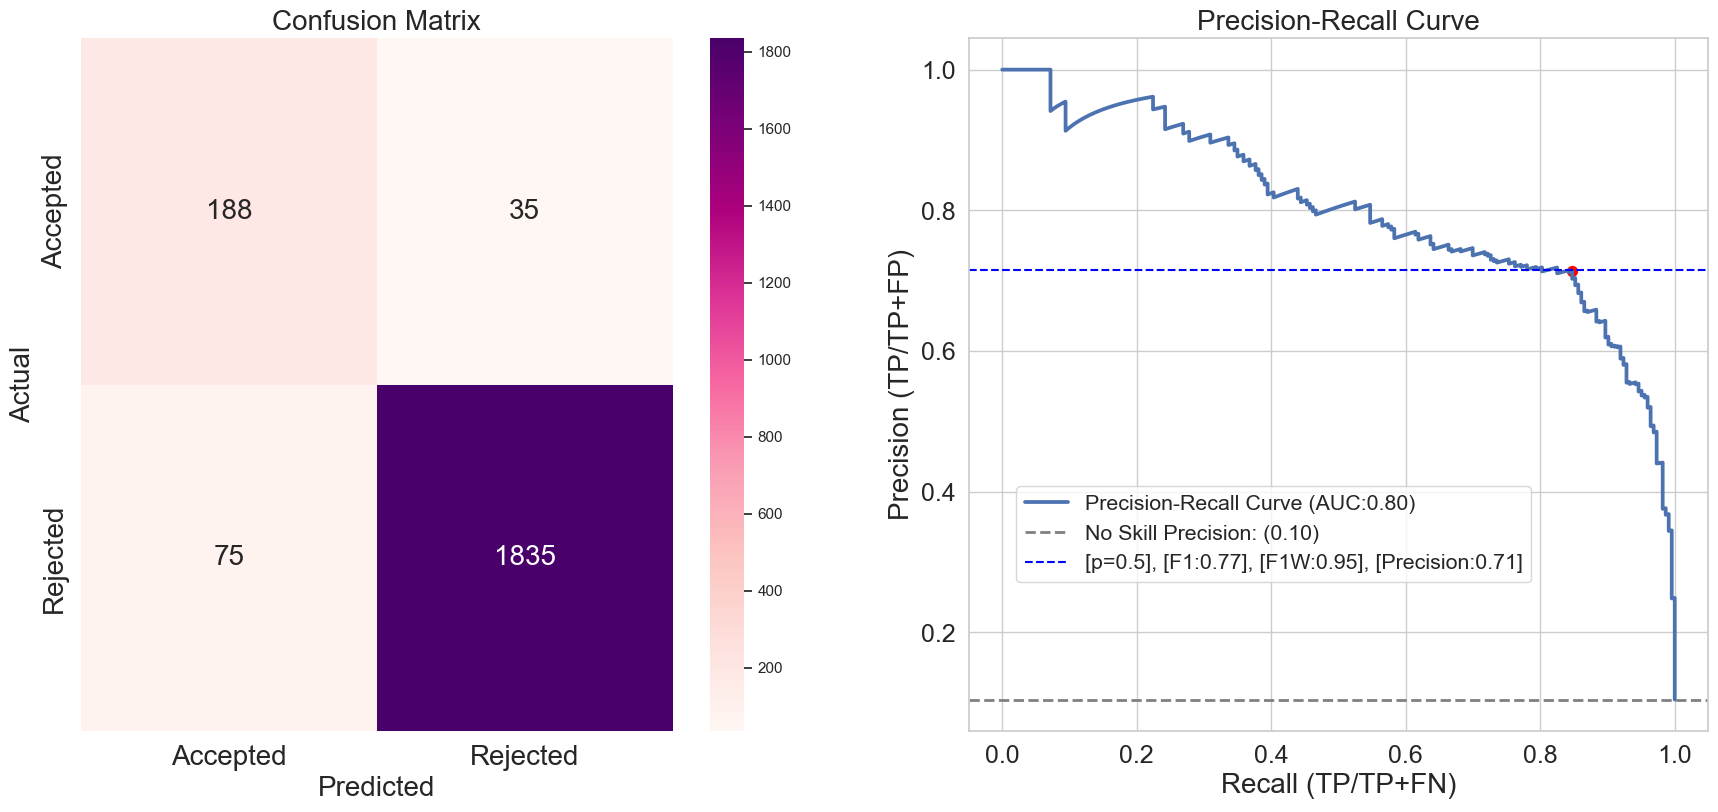

In [7]:
myreload()
plot.conf_matrix_PRC(best_lgr, X_test, y_test, probas_pos_index=0, threshold=0.5,
                     common_fontsize=20, figx=21, figy=9, xlegend=0.05, ylegend=0.2) 

Increasing the Threshold increases Precision and decreases FPs but decreases Recall and increases FNs. Below we show an updated confusion matrix for threshold = 0.88

Reloaded helpers.preprocessing, helpers.plots, and helpers.tools.


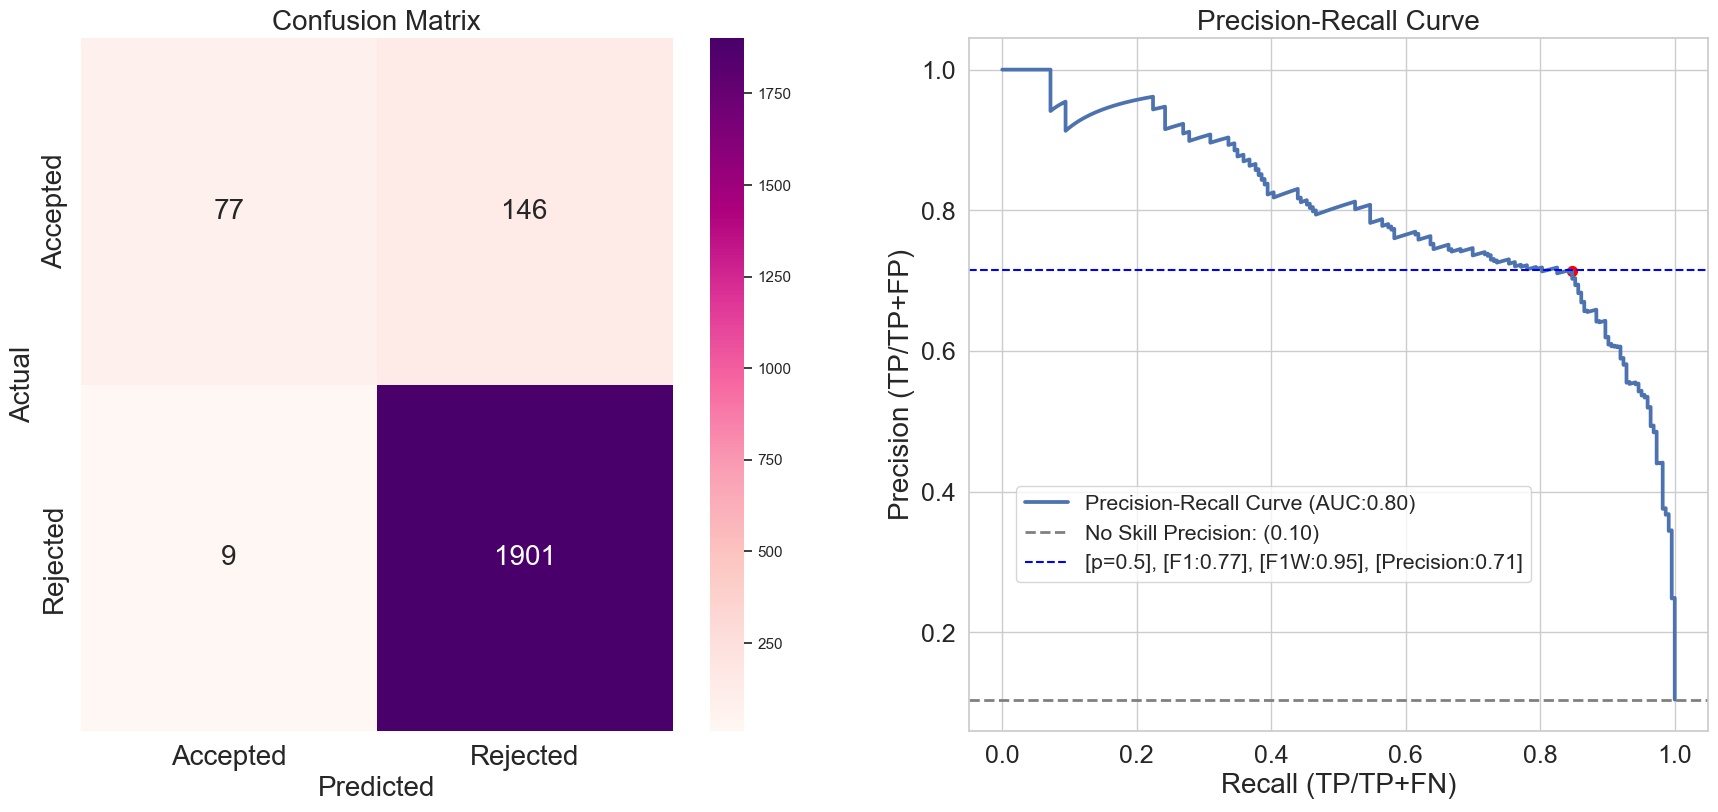

In [8]:
myreload()
plot.conf_matrix_PRC(best_lgr, X_test, y_test, probas_pos_index=0, threshold=0.88,
                     common_fontsize=20, figx=21, figy=9, xlegend=0.05, ylegend=0.2) 

### Load Best GradientBoostClassifier model (Also best overall)

In [10]:
best_gbc = load('models/hyperparam_tuning/ht_ens_set8.joblib')
best_gbc

Pipeline(steps=[('transformer',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('si',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('yeo',
                                                                   PowerTransformer()),
                                                                  ('poly',
                                                                   PolynomialFeatures(degree=1,
                                                                                      include_bias=False))]),
                                                  ['neg_to_billed',
                                                   'offer_to_neg',
                                                   'offer_to_counter_offer',
                                                   'offer_days',
                                                   'decision_days',
                                                   'service_days',
                                                   'counter_offer_days',
                                                   'YOB']),
                                                 (...
                ('scaler', RobustScaler()),
                ('selector',
                 SelectFromModel(estimator=LogisticRegression(max_iter=3000,
                                                              n_jobs=-1,
                                                              penalty='l1',
                                                              random_state=42,
                                                              solver='saga'))),
                ('gbc',
                 GradientBoostingClassifier(learning_rate=0.004, max_depth=2,
                                            max_features='sqrt',
                                            min_samples_leaf=48,
                                            min_samples_split=0.013750000000000002,
                                            n_estimators=3700, random_state=42,
                                            subsample=0.85))])

#### Confirm we have the right model and that train and test scores match Hyperparameter Tuning

In [11]:
X_gbc, y_gbc = X.copy(deep=True), y.copy(deep=True) 
X_gbc[X_gbc.select_dtypes(exclude=['number']).columns] = X_gbc.select_dtypes(exclude=['number']).astype('str')
y_gbc = y_gbc.map({'Accepted':1, 'Rejected':0})

In [12]:
#Split and stratify the data
X_train_gbc, X_test_gbc, y_train_gbc, y_test_gbc = train_test_split(X_gbc,y_gbc, stratify=y_gbc, test_size=0.25, random_state=42)
X_train_gbc.shape, X_test_gbc.shape, y_train_gbc.shape, y_test_gbc.shape

((6398, 20), (2133, 20), (6398,), (2133,))

In [13]:
y_pred_train = best_gbc.predict(X_train_gbc)
y_pred_test = best_gbc.predict(X_test_gbc)

# Calculating F1 score
f1w_train_gbc = f1_score(y_train_gbc, y_pred_train, average='weighted')
f1w_test_gbc = f1_score(y_test_gbc, y_pred_test, average='weighted')
f1w_train_gbc, f1w_test_gbc

(0.9513199673150076, 0.951527642572098)

## Model Evaluation 
Below is a confusion matrix and a Precision-Recall Curve for our best_gbc model

Reloaded helpers.preprocessing, helpers.plots, and helpers.tools.


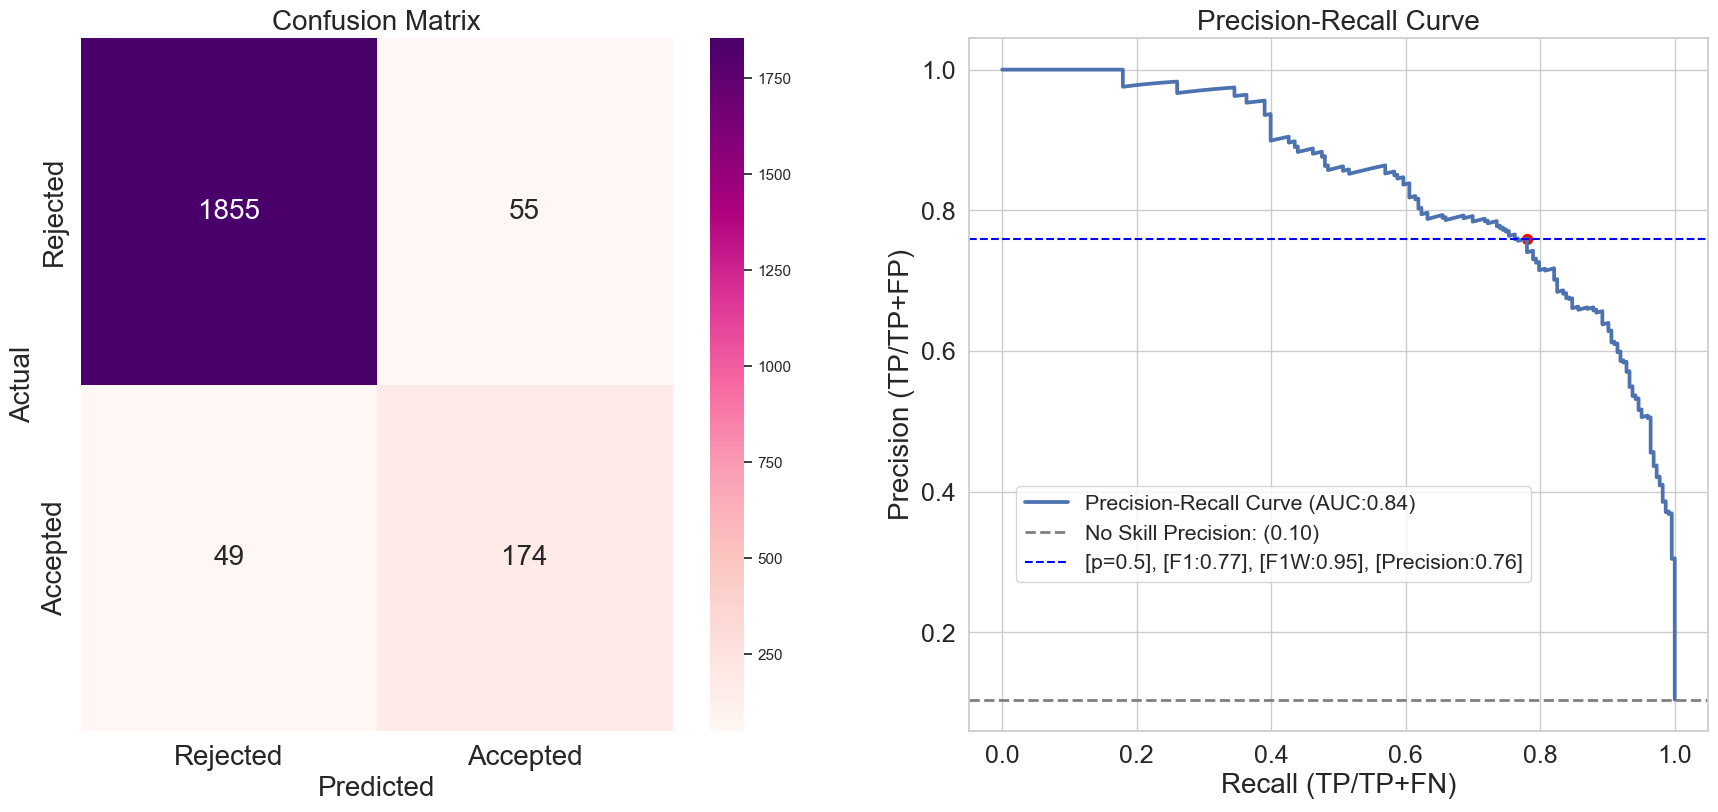

In [14]:
myreload()
plot.conf_matrix_PRC(best_gbc, X_test_gbc, y_test_gbc, probas_pos_index=1, class_labels=['Rejected', 'Accepted'], 
                     threshold=0.5,common_fontsize=20, figx=21, figy=9, xlegend=0.05, ylegend=0.2) 

Increasing our probability threshold means that the model would be more confident to predict an Acceptance.  This increases Precision (Fewer False Positives) but decreases Recall (more False Negatives).  Below we show that for our GradientBoosting model, we achieve 0 False Positives at threshold =0.88 although we this at the cost of an increase in our False Negatives

Reloaded helpers.preprocessing, helpers.plots, and helpers.tools.


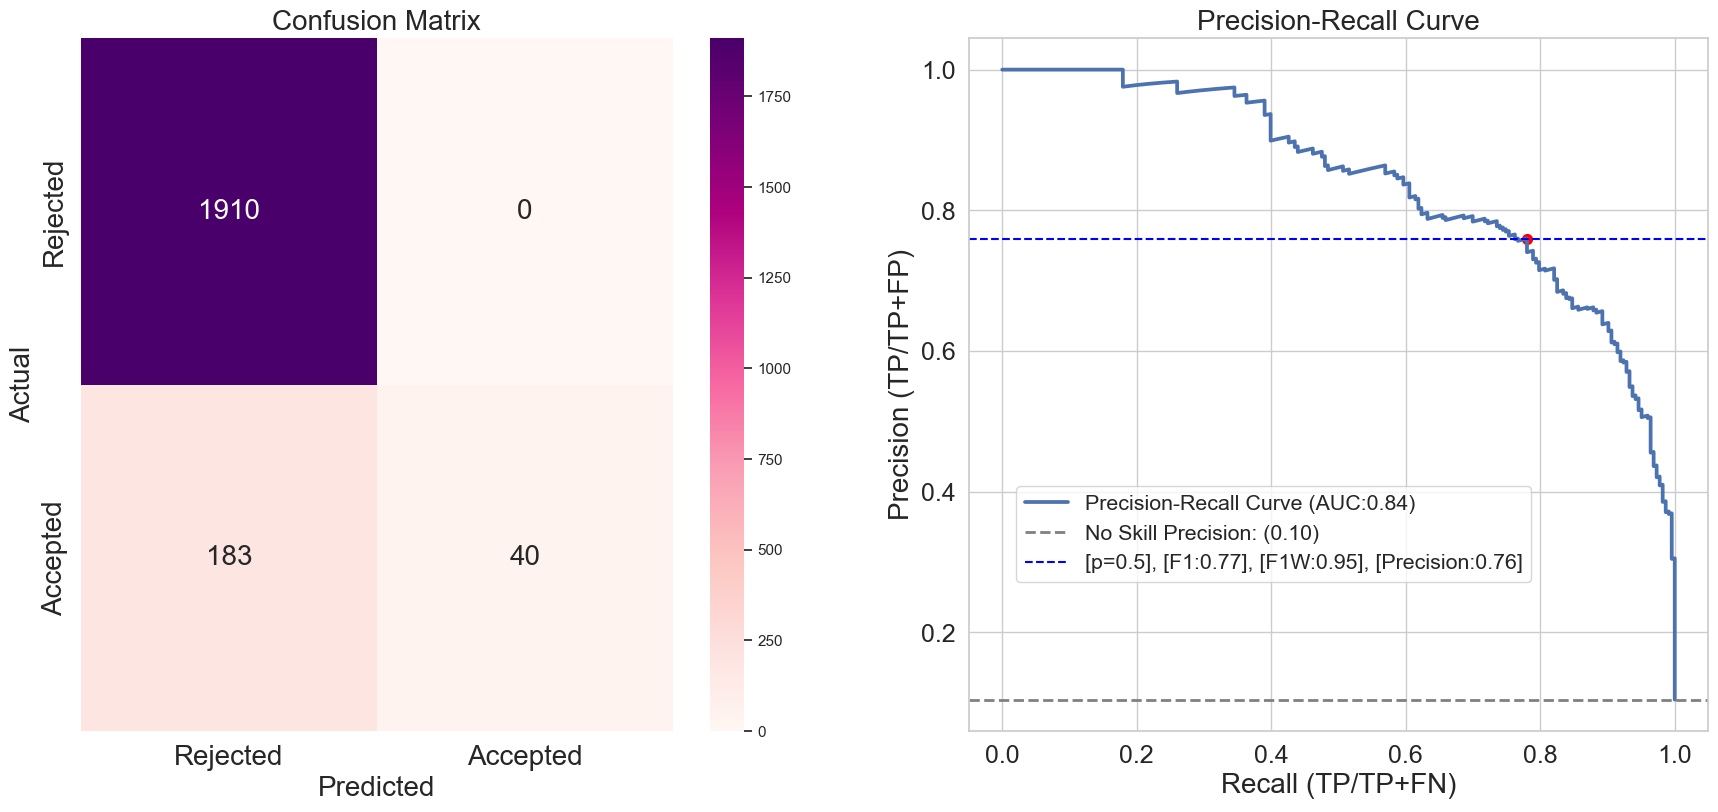

In [15]:
myreload()
plot.conf_matrix_PRC(best_gbc, X_test_gbc, y_test_gbc, probas_pos_index=1, class_labels=['Rejected', 'Accepted'], 
                     threshold=0.88,common_fontsize=20, figx=21, figy=9, xlegend=0.05, ylegend=0.2) 

The graph below shows the behavior of Precision, Recall and F1 vs. Thresholds

Reloaded helpers.preprocessing, helpers.plots, and helpers.tools.


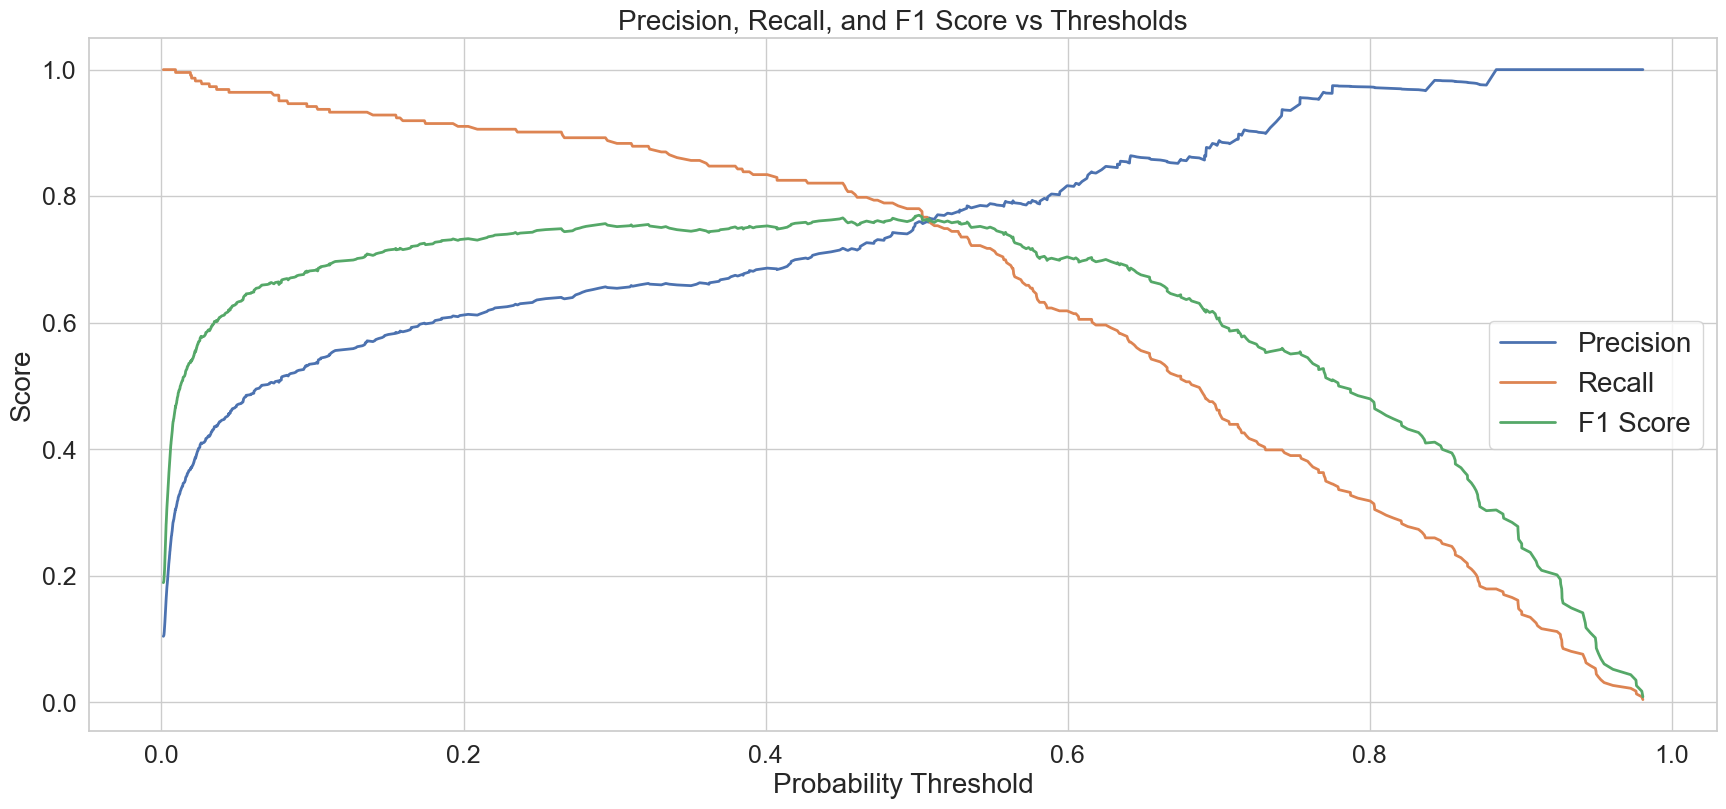

In [16]:
myreload()
plot.scores_vs_thresholds(best_gbc, X_test_gbc, y_test_gbc, probas_pos_index=1,  
                    common_fontsize=20, figx=21, figy=9)

### Summary of Findings
- We showed the coefficients of our best Logistic Regression Model even though it was a close 2nd overall.  This was done to show the relative importance of the features.  Ability to interpret the features was limited due to the fact that numerical values underwent a yeo-johnson transformation
- We also showed the confusion matrix and Precision-Curves for our best Logistic Regression Models and our best overall (GBC) model.  
- For both models, we also showed what happens when we increase the probability threshold to reduce the number of FNs which is something the Billing Department was interested in.